In [1]:
import numpy as np
from PIL import Image
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import random
from tabulate import tabulate
from tqdm import tqdm
import pandas as pd
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from collections import Counter
np.set_printoptions(suppress=True)
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
n_images = 250
my_number = 7
images = []

while len(images) != n_images:
    idx = random.randint(7, 25000)
    image_name = f'im{idx}.jpg'
    image = cv2.imread(glob.glob(f'./mirflickr/{image_name}')[0])[:, :, 1]
    #images.append((image_name, image))
    images.append(image)
    
images = np.asarray(images)
assert len(images) == n_images

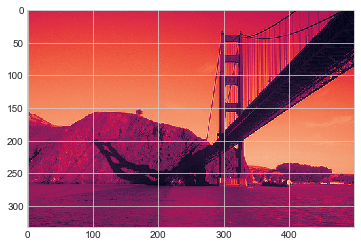

In [3]:
plt.imshow(images[0]);

# Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
 - Математичне очікування та дисперсію
 - Медіану та інтерквартильний розмах
 - Коефіцієнти асиметрії та ексцесу (нормалізований)
 - Гістограму значень яскравості пікселів (нормалізовану)

In [4]:
def count_statistics(img, normalized = False):
    math_exp_ = np.mean(img)
    variance_ = np.var(img)
    median_ = np.median(img)
    IQR_ = iqr(img.reshape(-1))
    if normalized:
        img = img / 255.
    kurtosis_ = kurtosis(img.reshape(-1), fisher=True)
    skew_ = skew(img.reshape(-1))
    return math_exp_, variance_, median_, IQR_, kurtosis_, skew_

In [5]:
def plot_hist(image, distribution_label = None):
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True);
    plt.figure(figsize=(10, 6));
    sns.distplot(image.reshape(-1), kde=False, ax=axes[0]);
    if distribution_label == 't':
        sns.distplot(image.reshape(-1), fit=t, kde=False, ax=axes[1]);
    elif distribution_label == 'beta':
        sns.distplot(image.reshape(-1), fit=beta, kde=False, ax=axes[1]);
    elif distribution_label == 'laplace':
        sns.distplot(image.reshape(-1), fit=laplace, kde=False, ax=axes[1]);
    elif distribution_label == 'norm':
        sns.distplot(image.reshape(-1), fit=norm, kde=False, ax=axes[1]);
    plt.show();

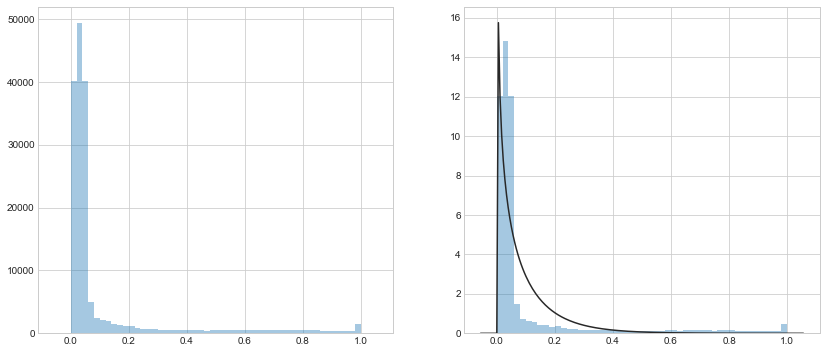

<Figure size 720x432 with 0 Axes>

In [6]:
plot_hist(images[116] / 255., 'beta');

# Провести обробку отриманих гістограм:
 - Провести апроксимацію гістограм з використанням імовірнісних розподілів:
     - Нормального (гаусового) розподілу
     - Розподілу Лапласа
     - Розподілу Стьюдента
     - Бета розподілу
 - Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
 - Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

In [7]:
def approx_array(img):
    img = img.reshape(-1)
    space = np.linspace(0, 255, num=256)
    sse_min = 10**100
    res_distribution = None
    arr = []
    for i in range(256):
        arr.append(Counter(img)[i])
    
    for distribution in [norm, t, laplace, beta]:
        # fit dist to data
        params = distribution.fit(img)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        pdf = distribution.pdf(space, loc=loc, scale=scale, *arg)
            
        sse = np.sum(np.power(arr - pdf, 2.0))
            
        if sse <= sse_min:
            sse_min = sse
            res_distribution = distribution
            
    return res_distribution, sse_min, str(res_distribution).split('.')[3].split(' ')[0].split('_')[0]

In [8]:
def sample_stats(image):
    math_exp, variance, median, IQR_, kurtosis_, skew_ = count_statistics(image)
    print('=========== stats table ===========')
    print(tabulate([['math expectation', math_exp], 
                ['variance', variance], 
                ['median', median],
                ['IQR', IQR_],
                ['kurtosis', kurtosis_], 
                ['skew', skew_]]))
    
    distribution, sse, distribution_label = approx_array(image)
    print('=========== distribution approximation =========')
    print('distribution : ', distribution_label)
    print('squared error : ', sse)
    
    print('=========== Plotting graph =========')
    plot_hist(image, distribution_label)

199
=========== stats table ===========
----------------  -----------
math expectation   120.971
variance          7511.88
median              99
IQR                169
kurtosis            -1.32411
skew                 0.355644
----------------  -----------
=========== distribution approximation =========
distribution :  t
squared error :  199788569.3597437
=========== Plotting graph =========


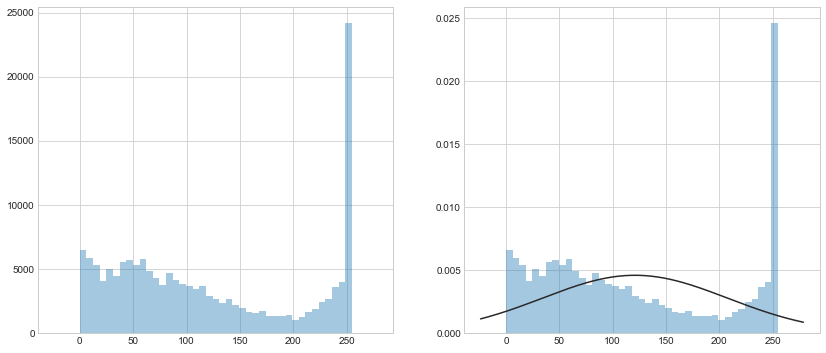

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
29
=========== stats table ===========
----------------  -----------
math expectation    63.6612
variance          2994.53
median              51
IQR                 83
kurtosis            -0.245633
skew                 0.787968
----------------  -----------
=========== distribution approximation =========
distribution :  laplace
squared error :  316405009.1327975
=========== Plotting graph =========


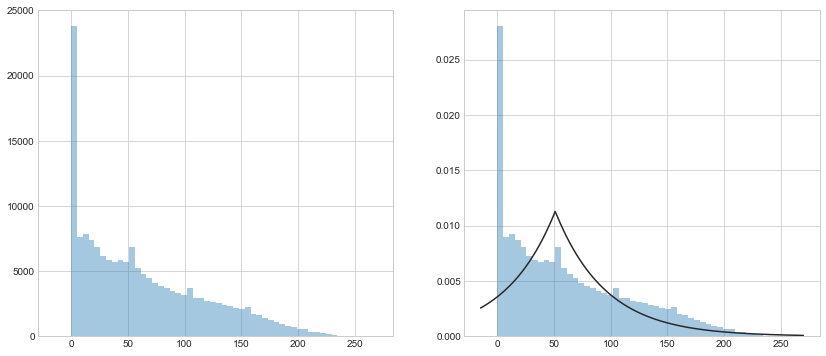

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
222
=========== stats table ===========
----------------  ----------
math expectation    72.1883
variance          3977.67
median              40
IQR                115
kurtosis            -1.10943
skew                 0.58586
----------------  ----------
=========== distribution approximation =========
distribution :  laplace
squared error :  290041833.7333475
=========== Plotting graph =========


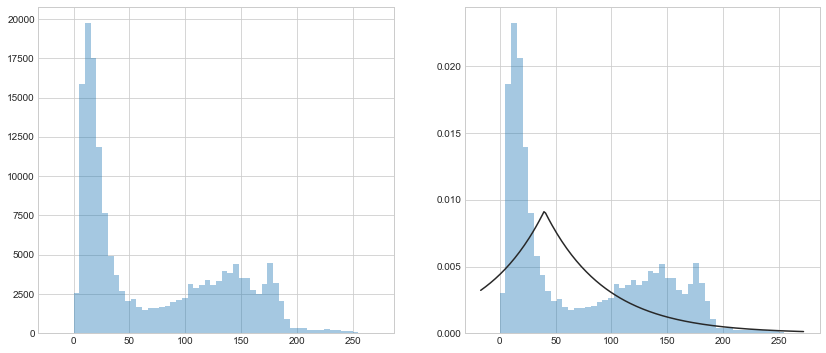

<Figure size 720x432 with 0 Axes>

************************************************************************************************************


In [9]:
n_samples = 3
for image_idx in np.random.choice(250, n_samples):
    print(image_idx)
    sample_stats(images[image_idx])
    print('******************************************************'*2)

In [10]:
distr_values = list()
for i, image in enumerate(images):
    _, _, distr = approx_array(image)
    print(i, distr)
    distr_values.append(distr)

0 beta
1 laplace
2 beta
3 t
4 t
5 beta
6 beta
7 beta
8 laplace
9 beta
10 beta
11 beta
12 laplace
13 laplace
14 t
15 laplace
16 laplace
17 beta
18 laplace
19 beta
20 laplace
21 beta
22 t
23 laplace
24 laplace
25 laplace
26 t
27 t
28 beta
29 laplace
30 laplace
31 beta
32 laplace
33 laplace
34 laplace
35 beta
36 beta
37 laplace
38 laplace
39 laplace
40 beta
41 t
42 norm
43 laplace
44 beta
45 beta
46 beta
47 beta
48 t
49 norm
50 t
51 laplace
52 beta
53 beta
54 beta
55 beta
56 norm
57 beta
58 beta
59 norm
60 beta
61 t
62 laplace
63 beta
64 beta
65 laplace
66 laplace
67 beta
68 laplace
69 laplace
70 laplace
71 t
72 laplace
73 t
74 laplace
75 laplace
76 beta
77 laplace
78 beta
79 t
80 laplace
81 laplace
82 laplace
83 laplace
84 norm
85 beta
86 beta
87 beta
88 laplace
89 laplace
90 beta
91 beta
92 beta
93 laplace
94 norm
95 norm
96 laplace
97 norm
98 norm
99 beta
100 t
101 t
102 t
103 beta
104 beta
105 norm
106 laplace
107 laplace
108 laplace
109 norm
110 beta
111 beta
112 laplace
113 laplace


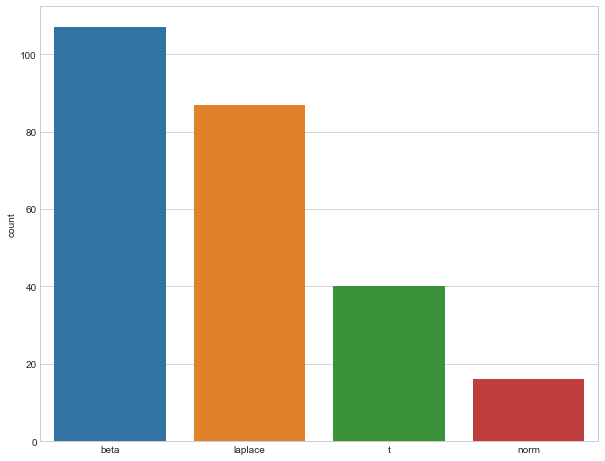

In [11]:
plt.figure(figsize=(10, 8))
sns.countplot(distr_values);

# Побудувати багатовимірні гаусові моделі
Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень:
 - Математичне очікування
 - Математичне очікування та дисперсія
 - Математичне очікування, дисперсія та коефіцієнт асиметрії
 - Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

In [12]:
def group_statistics(data):
    math_exp_arr = []
    var_arr = []
    skew_arr = []
    kurt_arr = []
    for image in data:
        image_stats = count_statistics(image)
        math_exp_arr.append(image_stats[0])
        var_arr.append(image_stats[1])
        skew_arr.append(image_stats[4])
        kurt_arr.append(image_stats[5])
    return math_exp_arr, var_arr, skew_arr, kurt_arr

In [13]:
math_exp, var, skew, kurt = group_statistics(images)

Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

mean_vec:  103.92770158107925
cov_matrix: 
 1558.5525396704072


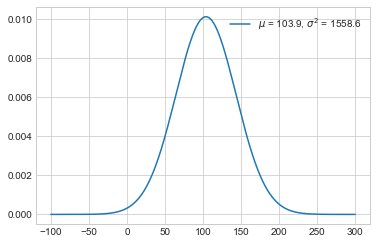

In [14]:
# 1. Math exp 
sample = math_exp
mean_vec_1 = np.mean(sample)
cov_matrix_1 = np.cov(sample)
print('mean_vec: ', mean_vec_1)
print('cov_matrix: \n', cov_matrix_1) 

x = np.linspace(start = -100, stop = 300, num = 2000)
y = norm(mean_vec_1, np.sqrt(cov_matrix_1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(mean_vec_1, 1), np.round(cov_matrix_1, 1)))
plt.legend();

mean_vec:  103.92770158107925 4116.821561653695
cov_matrix: 
 [[   1558.55253967   14806.59460987]
 [  14806.59460987 4732305.20494702]]


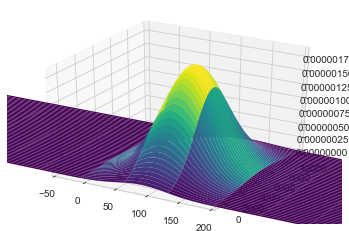

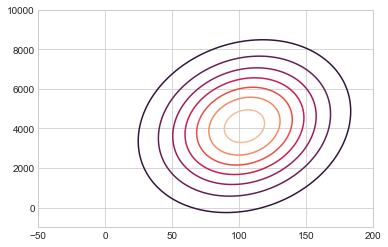

In [15]:
# 2. Math exp, Variance
sample = np.vstack((math_exp, var))
mean_vec_2 = np.mean(sample, axis=1)
cov_matrix_2 = np.cov(sample)
print('mean_vec: ', *mean_vec_2)
print('cov_matrix: \n', cov_matrix_2) 


x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(mean_vec_2, cov_matrix_2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

In [16]:
# 3. Math exp, Variance, Skew
sample = np.vstack((math_exp, var, skew))
mean_vec_3 = np.mean(sample, axis=1)
cov_matrix_3 = np.cov(sample)
print('mean_vec: ', *mean_vec_3)
print('cov_matrix: \n', cov_matrix_3) 

mean_vec:  103.92770158107925 4116.821561653695 0.3527614264643043
cov_matrix: 
 [[   1558.55253967   14806.59460987      -1.08074484]
 [  14806.59460987 4732305.20494702   -3187.02055034]
 [     -1.08074484   -3187.02055034      13.90317787]]


In [17]:
# 4. Math exp, Variance, Skew, Kurtosis
sample = np.vstack((math_exp, var, skew, kurt))
mean_vec_4 = np.mean(sample, axis=1)
cov_matrix_4 = np.cov(sample)
print('mean_vec: ', *mean_vec_4)
print('cov_matrix: \n', cov_matrix_4)               

mean_vec:  103.92770158107925 4116.821561653695 0.3527614264643043 0.3236589206618077
cov_matrix: 
 [[   1558.55253967   14806.59460987      -1.08074484     -33.00238397]
 [  14806.59460987 4732305.20494702   -3187.02055034    -148.73167754]
 [     -1.08074484   -3187.02055034      13.90317787       0.34344415]
 [    -33.00238397    -148.73167754       0.34344415       0.91713716]]
